# Multi Layer Perceptron Model

- BOOK: [Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/) by Jason Brownlee
- NOTES: [TS -> ML split function](https://detraviousjbrinkley.notion.site/TS-ML-split-function-9ab51cbb49d244aa8b4ab434d009f8a7?pvs=4) by Detravious J.B. 
    - See for Forecast vs Prediction

In [43]:
!pip3 install torchviz keras tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 252.5 MB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 21.9 MB/s eta 0:00:01
     |████████████████████████████████| 417 kB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 5.5 MB 32.8 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 31.1 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 224 kB 30.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [44]:
import os
import sys
import torch

import numpy as np
import pandas as pd

import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../framework_for_time_series_data/tslearn/'))
from ml_models import MLP
from ts_models import EvaluationMetric

In [45]:
observations = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Book's implementation

In [46]:
def split_sequence(sequence, n_steps_in, n_steps_out): 
    X, y = list(), list() 
    for i in range(len(sequence)): 
        # find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        # check if we are beyond the sequence 
        if out_end_ix > len(sequence): 
            break
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [47]:
X, y = split_sequence(observations, 3, 3)

In [48]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [49]:
y

array([[40, 50, 60],
       [50, 60, 70],
       [60, 70, 80],
       [70, 80, 90]])

# My implementation

In [50]:
def convert_uts_sequence_to_sml(uts_observations, prior_observations, forecasting_step):
    """Splits a given UTS into multiple input rows where each input row has a specified number of timestamps and the output is a single timestamp.
    
    Parameters:
    uts_observations -- 1D np array (of UTS data to transform to SML data with size  b rows/length x 1 dimension)
    prior_observations -- py int (of all observations before we get to where we want to start making the predictions)
    forecasting_step -- py int (of how far out to forecast, 1 only the next timestamp, 2 the next two timestamps, ... n the next n timestamps)
    
    Return:
    agg.values -- np array (of new sml data)
    """
    
    df = pd.DataFrame(uts_observations)
    cols = list()
    
    lag_col_names = []
    count_lag = 0
    # input sequence (t-n, ... t-1)
    for prior_observation in range(prior_observations, 0, -1):
        # print("prior_observation: ", prior_observation)
        cols.append(df.shift(prior_observation))
        new_col_name = "t - " + str(prior_observation)
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecasting_step):
        cols.append(df.shift(-i))
        # print(f"t + {i}")
        if i == 0:
            new_col_name = f"t"
        else:
            new_col_name = f"t + {i}"
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
        # put it all together
        uts_sml_df = pd.concat(cols, axis=1) 
        uts_sml_df.columns=[lag_col_names]
        # drop rows with NaN values
        uts_sml_df.dropna(inplace=True)
    
    # print(uts_sml_df)
    
    # colums to use to make prediction for last col
    X_train = uts_sml_df.iloc[:, 0: -1]
    
    # last column
    y_train = uts_sml_df.iloc[:, [-1]]
    return uts_sml_df

In [51]:
n_steps = 3
output_size = 2
converted_seq_df = convert_uts_sequence_to_sml(observations, n_steps, output_size)

In [52]:
converted_seq_df

,t - 3,t - 2,t - 1,t,t + 1
3,10.0,20.0,30.0,40,50.0
4,20.0,30.0,40.0,50,60.0
5,30.0,40.0,50.0,60,70.0
6,40.0,50.0,60.0,70,80.0
7,50.0,60.0,70.0,80,90.0


In [53]:
forecast_X_train_df = converted_seq_df.iloc[:, :n_steps]
forecast_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0
7,50.0,60.0,70.0


In [54]:
forecast_y_train_df = converted_seq_df.iloc[:, -output_size:]
forecast_y_train_df

,t,t + 1
3,40,50.0
4,50,60.0
5,60,70.0
6,70,80.0
7,80,90.0


In [55]:
forecast_X_test_df = converted_seq_df.iloc[[-1], -n_steps:]
forecast_X_test_df

,t - 1,t,t + 1
7,70.0,80,90.0


In [56]:
predict_X_train_df = converted_seq_df.iloc[:-1, :n_steps]
predict_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0


In [57]:
predict_y_train_df = converted_seq_df.iloc[:-1, -output_size:]
predict_y_train_df

,t,t + 1
3,40,50.0
4,50,60.0
5,60,70.0
6,70,80.0


In [58]:
predict_X_test_df = converted_seq_df.iloc[[-n_steps], -n_steps:]
predict_X_test_df

,t - 1,t,t + 1
5,50.0,60,70.0


In [59]:
predict_y_test_df = converted_seq_df.iloc[[-1], -output_size:]
predict_y_test_df

,t,t + 1
7,80,90.0


# Book's implementation
- Keras

## Forecast model

In [60]:
from keras.models import Sequential 
from keras.layers import Dense

forecast_model = Sequential() 
forecast_model.add(Dense(100, activation='relu' , input_dim=n_steps)) 
forecast_model.add(Dense(output_size)) 
forecast_model.compile(optimizer='adam' , loss='mse') 

predict_model = Sequential() 
predict_model.add(Dense(100, activation='relu' , input_dim=n_steps)) 
predict_model.add(Dense(output_size)) 
predict_model.compile(optimizer='adam' , loss='mse') 

/Users/detraviousjamaribrinkley/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
# fit model 
forecast_model.fit(forecast_X_train_df, forecast_y_train_df, epochs=2000, verbose=0)

In [22]:
forecast_X_test = np.array(forecast_X_test_df)
forecast_X_test, forecast_X_test.shape[0]

(array([[70., 80., 90.]]), 1)

In [23]:
X_test = forecast_X_test.reshape((forecast_X_test.shape[0]), n_steps)
X_test

array([[70., 80., 90.]])

In [62]:
forecasts = forecast_model.predict(X_test, verbose=0)
forecasts

array([[102.27615 , 115.172455]], dtype=float32)

## Predict model

In [63]:
predict_model.fit(predict_X_train_df, predict_y_train_df, epochs=20, verbose=0)

In [64]:
predict_X_test = np.array(predict_X_test_df)
predict_X_test, predict_X_test.shape[0]

(array([[50., 60., 70.]]), 1)

In [65]:
predict_X_test = forecast_X_test.reshape((predict_X_test.shape[0]), n_steps)
predict_X_test

array([[70., 80., 90.]])

In [66]:
book_model_predictions = predict_model.predict(predict_X_test, verbose=0)
book_model_predictions

array([[70.81254 , 44.407104]], dtype=float32)

In [67]:
predict_y_test_df

,t,t + 1
7,80,90.0


In [68]:
EvaluationMetric.eval_mse(predict_y_test_df, book_model_predictions, False)

Test MSE: 1081.561


## My implementation

- Using my TSLearn library

### Prediction model

- Interpolation of in sample values 
- Use `50, 60, 70`, so X_test
- True predictions `80, 90`, so y_test

### Forecast model

- Extrapolation of future values `
- Use `70, 80, 90`, so X_test
- Expected `100, 110`. We say expected because we don't know the actual values, thus no y_test. Expected as in we increment by 10.

In [69]:
hidden_size = 100

mlp_predict_model = MLP(n_steps, hidden_size, output_size)
mlp_predict_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [70]:
mlp_forecast_model = MLP(n_steps, hidden_size, output_size)
mlp_forecast_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [71]:
forecast_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0
7,50.0,60.0,70.0


In [72]:
# #times to loop through the training
# Hyperparameter
epochs = 2000
criterion = nn.MSELoss()

predict_optimizer = torch.optim.Adam(mlp_predict_model.parameters())
predict_configs = [criterion, predict_optimizer]

forecast_optimizer = torch.optim.Adam(mlp_forecast_model.parameters())
forecast_configs = [criterion, forecast_optimizer]

# Track different setups (ie: lr, etc) to compare this experiment to future experiments
epoch_count = []
train_pred_values = []
test_pred_values = []

predict_train_loss_values = []
predict_test_loss_values = []

forecast_train_loss_values = []
forecast_test_loss_values = []

### Training
# 0. Loop through the training
for epoch in tqdm(range(epochs)):

    # In-Sample Prediction
    train_predictions, predict_train_loss = mlp_predict_model.train_model(predict_X_train_df, predict_y_train_df, predict_configs)
    test_predictions, predict_test_loss = mlp_predict_model.interpolate_predictions(predict_X_test_df, predict_y_test_df, predict_configs)
    
    # Out-Sample Forecasts
    train_forecasts, forecast_train_loss = mlp_forecast_model.train_model(forecast_X_train_df, forecast_y_train_df, forecast_configs)
    test_forecasts = mlp_forecast_model.extrapolate_forecasts(forecast_X_test_df)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        print(f"Epoch: {epoch}")

        print(f"    Predictions | Train loss: {predict_train_loss} | Test loss: {predict_test_loss}")
        # print(f"    Predictions Parameters: {mlp_predict_model.state_dict()}")
        predict_train_loss_values.append(predict_train_loss)
        predict_test_loss_values.append(predict_test_loss)

        print(f"    Forecasts | Train loss: {forecast_train_loss}")
        # print(f"    Forecasts Parameters: {mlp_forecast_model.state_dict()}")
        forecast_train_loss_values.append(forecast_train_loss)
        # print()

 22%|██▏       | 446/2000 [00:00<00:00, 2260.35it/s]

Epoch: 0
    Predictions | Train loss: 3612.525390625 | Test loss: 6705.201171875
    Forecasts | Train loss: 3860.21484375
Epoch: 10
    Predictions | Train loss: 2514.178955078125 | Test loss: 4318.04345703125
    Forecasts | Train loss: 2439.859130859375
Epoch: 20
    Predictions | Train loss: 1615.9520263671875 | Test loss: 2449.9228515625
    Forecasts | Train loss: 1360.2803955078125
Epoch: 30
    Predictions | Train loss: 930.2633056640625 | Test loss: 1128.3590087890625
    Forecasts | Train loss: 629.0550537109375
Epoch: 40
    Predictions | Train loss: 465.7862243652344 | Test loss: 361.6680603027344
    Forecasts | Train loss: 224.9041748046875
Epoch: 50
    Predictions | Train loss: 204.73916625976562 | Test loss: 64.7137222290039
    Forecasts | Train loss: 74.0799789428711
Epoch: 60
    Predictions | Train loss: 91.78459930419922 | Test loss: 53.30860900878906
    Forecasts | Train loss: 52.65333938598633
Epoch: 70
    Predictions | Train loss: 56.633426666259766 | Test l

 46%|████▋     | 927/2000 [00:00<00:00, 2355.36it/s]

Epoch: 490
    Predictions | Train loss: 8.595949172973633 | Test loss: 43.549560546875
    Forecasts | Train loss: 3.4727587699890137
Epoch: 500
    Predictions | Train loss: 8.054636001586914 | Test loss: 41.81932830810547
    Forecasts | Train loss: 3.1126437187194824
Epoch: 510
    Predictions | Train loss: 7.538937568664551 | Test loss: 39.920570373535156
    Forecasts | Train loss: 2.7850518226623535
Epoch: 520
    Predictions | Train loss: 7.045387268066406 | Test loss: 38.228580474853516
    Forecasts | Train loss: 2.483768939971924
Epoch: 530
    Predictions | Train loss: 6.579269886016846 | Test loss: 36.588565826416016
    Forecasts | Train loss: 2.2110962867736816
Epoch: 540
    Predictions | Train loss: 6.134133815765381 | Test loss: 34.88982009887695
    Forecasts | Train loss: 1.9640388488769531
Epoch: 550
    Predictions | Train loss: 5.713842391967773 | Test loss: 33.33481979370117
    Forecasts | Train loss: 1.7407481670379639
Epoch: 560
    Predictions | Train loss: 

 70%|███████   | 1405/2000 [00:00<00:00, 2355.39it/s]

Epoch: 980
    Predictions | Train loss: 0.09159791469573975 | Test loss: 7.666587829589844
    Forecasts | Train loss: 0.002462598495185375
Epoch: 990
    Predictions | Train loss: 0.08100102841854095 | Test loss: 7.571208477020264
    Forecasts | Train loss: 0.0020720355678349733
Epoch: 1000
    Predictions | Train loss: 0.07144390046596527 | Test loss: 7.4520368576049805
    Forecasts | Train loss: 0.0017416926566511393
Epoch: 1010
    Predictions | Train loss: 0.06300245225429535 | Test loss: 7.3583455085754395
    Forecasts | Train loss: 0.0014627411728724837
Epoch: 1020
    Predictions | Train loss: 0.05545007437467575 | Test loss: 7.266138553619385
    Forecasts | Train loss: 0.0012275691842660308
Epoch: 1030
    Predictions | Train loss: 0.048756152391433716 | Test loss: 7.165471076965332
    Forecasts | Train loss: 0.001029315171763301
Epoch: 1040
    Predictions | Train loss: 0.04285266995429993 | Test loss: 7.096758842468262
    Forecasts | Train loss: 0.0008622694876976311


 94%|█████████▍| 1887/2000 [00:00<00:00, 2382.67it/s]

Epoch: 1460
    Predictions | Train loss: 0.0002548148622736335 | Test loss: 6.098480224609375
    Forecasts | Train loss: 1.54247388195472e-07
Epoch: 1470
    Predictions | Train loss: 0.00024084217147901654 | Test loss: 6.097908020019531
    Forecasts | Train loss: 1.231179282967787e-07
Epoch: 1480
    Predictions | Train loss: 0.00022865259961690754 | Test loss: 6.097314357757568
    Forecasts | Train loss: 9.727373395662653e-08
Epoch: 1490
    Predictions | Train loss: 0.00021770462626591325 | Test loss: 6.096795558929443
    Forecasts | Train loss: 7.674388768919016e-08
Epoch: 1500
    Predictions | Train loss: 0.00020806703832931817 | Test loss: 6.096225738525391
    Forecasts | Train loss: 5.861074825475043e-08
Epoch: 1510
    Predictions | Train loss: 0.00019957330368924886 | Test loss: 6.0957231521606445
    Forecasts | Train loss: 4.5748311805482444e-08
Epoch: 1520
    Predictions | Train loss: 0.00019201880786567926 | Test loss: 6.095250129699707
    Forecasts | Train loss: 

100%|██████████| 2000/2000 [00:00<00:00, 2352.61it/s]

Epoch: 1950
    Predictions | Train loss: 0.00013431679690256715 | Test loss: 6.088793754577637
    Forecasts | Train loss: 3.434252049405728e-10
Epoch: 1960
    Predictions | Train loss: 0.00013421641779132187 | Test loss: 6.088823318481445
    Forecasts | Train loss: 3.1868693795011893e-10
Epoch: 1970
    Predictions | Train loss: 0.0001340676099061966 | Test loss: 6.088793754577637
    Forecasts | Train loss: 2.9685906510756865e-10
Epoch: 1980
    Predictions | Train loss: 0.00013398198643699288 | Test loss: 6.088809013366699
    Forecasts | Train loss: 2.721208258726904e-10
Epoch: 1990
    Predictions | Train loss: 0.00013394173583947122 | Test loss: 6.088846206665039
    Forecasts | Train loss: 2.721208258726904e-10


In [73]:
EvaluationMetric.eval_mse(predict_y_test_df, test_predictions, False) # Matches Test MSE

Test MSE: 6.089


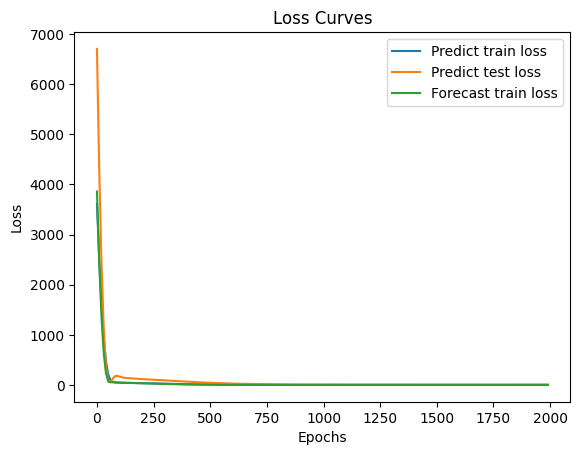

In [74]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(predict_train_loss_values).numpy()), label="Predict train loss")
plt.plot(epoch_count, predict_test_loss_values, label="Predict test loss")

plt.plot(epoch_count, np.array(torch.tensor(forecast_train_loss_values).numpy()), label="Forecast train loss")

plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();